In [17]:
import numpy as np
import pandas as pd
from scipy import io
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

In [18]:
# b2c cells_adata_path = "/srv/gstore/projects/p1001/EzPyzBin2CellApp_2025-04-29--10-56-12/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_v1_Experiment1/cdata.h5ad"
sushi_path = "https://fgcz-sushi.uzh.ch/projects/p37785/EzPyzENACTApp_2025-07-07--09-54-25/ENACTApp_Visium_HD_Human_Lung_Cancer_w_Xenium_seg/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_adata_path = sushi_path.replace("https://fgcz-sushi.uzh.ch/", "/srv/gstore/")
boxplot = False 
MECR_genes_path = './gene_pairs.csv'

In [19]:
# Loading Anndata object
adata_cells = sc.read_h5ad(cells_adata_path)
adata_cells.var_names_make_unique()

In [20]:
# Load the gene pairs CSV file
gene_pairs = pd.read_csv(MECR_genes_path)
print(gene_pairs.head(3))

   Gene1  Gene2
0  MS4A1  RAMP2
1  MS4A1  CLDN5
2  MS4A1    VWF


In [21]:
# Get unique gene names from both columns of gene_pairs
genes_of_interest = pd.unique(gene_pairs[['Gene1', 'Gene2']].values.ravel())

# Filter adata_cells to keep only these genes (columns)
genes_in_adata = [gene for gene in genes_of_interest if gene in adata_cells.var_names]
adata_cells_filtered = adata_cells[:, genes_in_adata].copy()
print(f"Filtered AnnData shape: {adata_cells_filtered.shape}")

Filtered AnnData shape: (164323, 17)


In [22]:
# Binarize the expression matrix for marker genes (1 if expressed, 0 otherwise)
X = adata_cells_filtered.X
X_bin = (X > 0)
X_bin = X_bin.astype(int)

# Compute coexpression matrix (gene x gene)
# Compute the sum of cells expressing each gene (across all cells)
gene_expr_sum = np.array(X_bin.sum(axis=0)).flatten()  # shape: (n_genes,)

# Create matrix where entry (i, j) = sum of cells expressing gene i + sum of cells expressing gene j
gene_expr_sum_matrix = gene_expr_sum[:, None] + gene_expr_sum[None, :]
coexpr = X_bin.T @ X_bin  # shape: (n_genes, n_genes)
# Subtract coexpression matrix from gene_expr_sum_matrix and normalize
norm_matrix = gene_expr_sum_matrix - coexpr
# Avoid division by zero
norm_matrix = np.where(norm_matrix == 0, 1, norm_matrix)
coexpr = coexpr / norm_matrix

coexpr = coexpr.toarray()

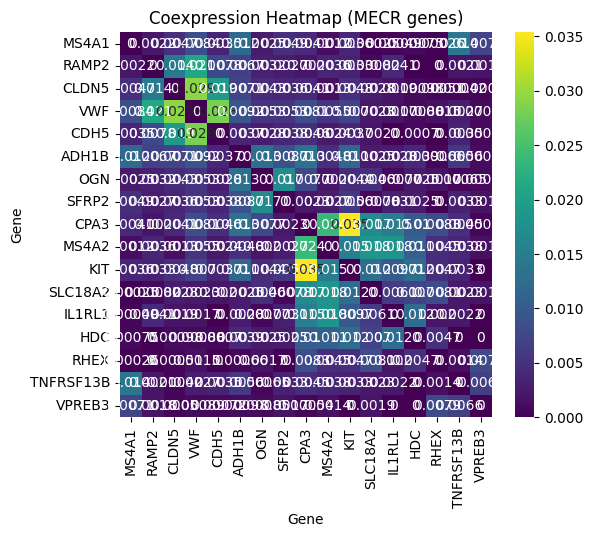

In [23]:
import seaborn as sns
np.fill_diagonal(coexpr, 0)
plt.figure(figsize=(6, 5))
sns.heatmap(coexpr, annot=True, xticklabels=genes_in_adata, yticklabels=genes_in_adata, cmap="viridis")
plt.title("Coexpression Heatmap (MECR genes)")
plt.xlabel("Gene")
plt.ylabel("Gene")
plt.show()

In [24]:
# Extract coexpression values for each gene pair in gene_pairs
coexpr_values = []
pair_labels = []

for idx, row in gene_pairs.iterrows():
    g1, g2 = row['Gene1'], row['Gene2']
    if g1 in genes_in_adata and g2 in genes_in_adata:
        i = genes_in_adata.index(g1)
        j = genes_in_adata.index(g2)
        coexpr_values.append(coexpr[i, j])
        pair_labels.append(f"{g1}-{g2}")

# Prepare DataFrame for plotting
coexpr_df = pd.DataFrame({'Gene Pair': pair_labels, 'Coexpression': coexpr_values})


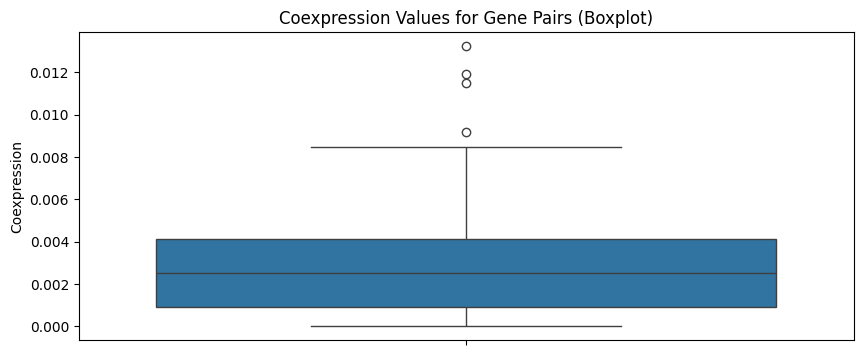

In [25]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=coexpr_df, y='Coexpression')
plt.title("Coexpression Values for Gene Pairs (Boxplot)")
plt.ylabel("Coexpression")
plt.xlabel("")
plt.show()


In [26]:
if boxplot:
    existing_df = pd.read_csv('MECR.csv')
    existing_df['Xseg'] = coexpr_df['Coexpression']
    existing_df.to_csv('MECR.csv', index=False)

In [27]:
# Calculate mean coexpression
mean_coexpr = coexpr_df['Coexpression'].mean()

# Calculate mean counts per cell for the filtered genes
mean_counts_per_cell = adata_cells.X.sum(axis=1).mean()

# Prepare DataFrame and save to CSV
summary_df = pd.DataFrame({
    'method': ['Xseg'],
    'mean_coexpression': [mean_coexpr],
    'mean_counts_per_cell': [mean_counts_per_cell]
})
#summary_df.to_csv('MECR_summary.csv', index=False) #Only used for the first run

# Load the existing MECR_summary.csv and append the new summary row
existing_summary = pd.read_csv('MECR_summary.csv')
updated_summary = pd.concat([existing_summary, summary_df], ignore_index=True)
updated_summary.to_csv('MECR_summary.csv', index=False)

In [28]:
# Extract counts for RAMP2 and MS4A2 for each cell, but only keep rows where at least one gene is expressed
ramp2_counts = adata_cells[:, 'RAMP2'].X.toarray().flatten()
ms4a2_counts = adata_cells[:, 'MS4A2'].X.toarray().flatten()
mask = (ramp2_counts > 0) | (ms4a2_counts > 0)
counts_df = pd.DataFrame({
    'RAMP2': ramp2_counts[mask],
    'MS4A2': ms4a2_counts[mask],
    'label': 'X_seg'
})

#counts_df.to_csv('RAMP2_MS4A2_counts_Xseg.csv', index=False)

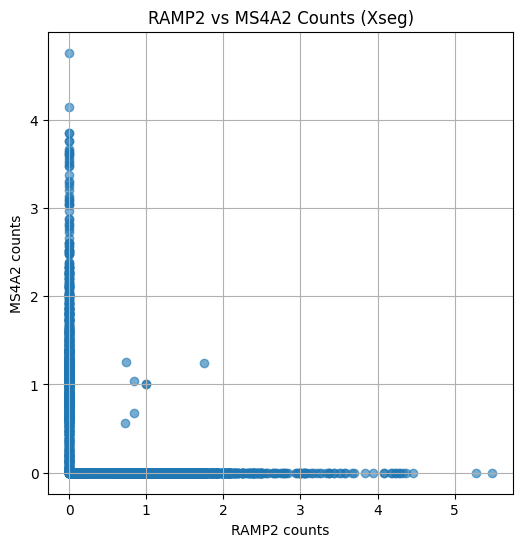

In [29]:
# Load the counts from CSV and plot scatterplot
df_counts = pd.read_csv('RAMP2_MS4A2_counts_Xseg.csv')
plt.figure(figsize=(6, 6))
plt.scatter(df_counts['RAMP2'], df_counts['MS4A2'], alpha=0.6)
plt.xlabel('RAMP2 counts')
plt.ylabel('MS4A2 counts')
plt.title('RAMP2 vs MS4A2 Counts (Xseg)')
plt.grid(True)
plt.show()

In [30]:
# Extract counts for CD74 and FTL for each cell, but only keep rows where at least one gene is expressed
cd74_counts = adata_cells[:, 'CD74'].X.toarray().flatten()
ftl_counts = adata_cells[:, 'FTL'].X.toarray().flatten()
mask = (cd74_counts > 0) | (ftl_counts > 0)
counts_df = pd.DataFrame({
    'CD74': cd74_counts[mask],
    'FTL': ftl_counts[mask],
    'label': 'X_seg'
})

#counts_df.to_csv('CD74_FTL_counts_Xseg.csv', index=False)